[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a2/execution.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/ai-unibo-nlp-project/blob/main/a2/execution.ipynb)

# Assignment 2 execution

In [59]:
%pip install pandas numpy matplotlib transformers==4.25.1  dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Reproducibility

In [60]:
def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Data loading

### Dataset download

In [61]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')
    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [62]:
data_folder = 'Dataset'

In [63]:
# Train & Validation data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path=data_folder, url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path=data_folder, url_path=test_url, suffix='test')

### Dataset loading

In [64]:
import numpy as np
import pandas as pd
import json
from os import path
from matplotlib import pyplot as plt

In [65]:
def load_coqa_dataset(filename:str) -> pd.DataFrame:
    with open(path.join(data_folder, filename)) as file_obj:
        data_arr = json.load(file_obj)["data"]
    print(f'{len(data_arr)} stories / {len(data_arr[0]["questions"])} questions in the first row')
    
    # Prepare the Categorical DTypes

    storyDType = pd.CategoricalDtype(pd.unique([story["story"] for story in data_arr]))
    print(f"{storyDType.categories.size} distinct stories")

    sourceDType = pd.CategoricalDtype(pd.unique([story["source"] for story in data_arr]))
    print(f"{sourceDType.categories.size} distinct sources: {sourceDType.categories}")
    
    # Transform into a numpy matrix (denormalization and categorical factorization)

    data_arr = np.array([
        [
            sourceDType.categories.get_loc(story["source"]), # Sources factorization
            storyDType.categories.get_loc(story["story"]), # Sources factorization
            story["questions"][question_index]["input_text"],
            story["answers"][question_index]["input_text"],
            story["answers"][question_index]["span_text"],
            #story["questions"][question_index]["turn_id"],
        ]
        for story in data_arr
        for question_index in range(len(story["questions"]))
        if story["answers"][question_index]["input_text"] != 'unknown'
    ])
    print(f'{data_arr.shape} question-answer pairs x columns')
    print(f'First row: {data_arr[0]}')
    
    # Transform into a DataFrame
    
    # https://marcobonzanini.com/2021/09/15/tips-for-saving-memory-with-pandas/
    # https://pandas.pydata.org/docs/user_guide/categorical.html
    return pd.DataFrame({
        "source": pd.Series(pd.Categorical.from_codes(data_arr[:,0].astype(np.int16), dtype=sourceDType)),
        "p": pd.Series(pd.Categorical.from_codes(data_arr[:,1].astype(np.int16), dtype=storyDType)),
        "q": data_arr[:,2],
        "a": data_arr[:,3],
        "span": data_arr[:,4],
    })

In [66]:
def append_shifted_question_to_coqa_dataset(df:pd.DataFrame, shift:int) -> (pd.DataFrame,int):
    if shift <= 0:
        raise Exception("shift must be greater than zero")
    history_mask = df["p"] == df["p"].shift(shift)
    history_series = df["q"].shift(shift).astype(str) + ' ' + df["a"].shift(shift) + '. ' + df["history"]
    df["history"] = np.where(history_mask, history_series, df["history"])
    return df, history_mask.sum()

In [67]:
def transform_coqa_dataset_with_history(df:pd.DataFrame, max_history_depth:int=3) -> pd.DataFrame:
    df["history"] = ""
    for i in range(1, max_history_depth+1):
        df, count = append_shifted_question_to_coqa_dataset(df, i)
        #print(i, count)
        if(count == 0):
            break;
    return df

In [68]:
train_df = load_coqa_dataset("train.json")
train_df.count()

7199 stories / 20 questions in the first row
6605 distinct stories
5 distinct sources: Index(['wikipedia', 'cnn', 'gutenberg', 'race', 'mctest'], dtype='object')
(107276, 5) question-answer pairs x columns
First row: ['0' '0' 'When was the Vat formally opened?'
 'It was formally established in 1475' 'Formally established in 1475']


source    107276
p         107276
q         107276
a         107276
span      107276
dtype: int64

In [70]:
pd.unique(train_df["p"]).size

6605

In [71]:
pd.unique(train_df["span"]).size

99470

In [72]:
pd.unique(train_df["source"]).size

5

In [73]:
train_df.head()

,source,p,q,a,span
0,wikipedia,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,Formally established in 1475
1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,he Vatican Library is a research library
2,wikipedia,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",Vatican Library is a research library for hist...
3,wikipedia,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology",Vatican Library is a research library for hist...
4,wikipedia,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project,"March 2014, the Vatican Library began an initi..."


In [74]:
train_df.memory_usage(deep=True)

Index          128
source      107764
p         14241201
q          9110271
a          7714655
span      12090637
dtype: int64

In [75]:
test_df = load_coqa_dataset("test.json")
test_df.count()

500 stories / 12 questions in the first row
499 distinct stories
5 distinct sources: Index(['mctest', 'race', 'cnn', 'wikipedia', 'gutenberg'], dtype='object')
(7917, 5) question-answer pairs x columns
First row: ['0' '0' 'What color was Cotton?' 'white'
 'a little white kitten named Cotton']


source    7917
p         7917
q         7917
a         7917
span      7917
dtype: int64

In [138]:
# # Example of concatenating question with history
# df2 = transform_coqa_dataset_with_history(train_df.head(50))
# df2.to_csv("x.csv")
# df2
df = transform_coqa_dataset_with_history(train_df.head(5))
questions = df[["q", "history"]].apply(" ".join, axis=1)
list(questions)

<ipython-input-67-ccc59ad8c287>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["history"] = ""
<ipython-input-66-457f5db7144a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["history"] = np.where(history_mask, history_series, df["history"])


['When was the Vat formally opened? ',
 'what is the library for? When was the Vat formally opened? It was formally established in 1475. ',
 'for what subjects? When was the Vat formally opened? It was formally established in 1475. what is the library for? research. ',
 'and? When was the Vat formally opened? It was formally established in 1475. what is the library for? research. for what subjects? history, and law. ',
 'what was started in 2014? what is the library for? research. for what subjects? history, and law. and? philosophy, science and theology. ']

## Data Pre-Processing

### Check unanswerable questions in the Train Dataset

In [76]:
idx = (train_df.a == 'unknown')
unanswerable = train_df[idx]
unanswerable.q.count()

0

All unanswerable questions in the Train Dataset have been already removed.

## Exploratory Data Analysis

In [77]:
train_df["p"][42]

'CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n"Lassiter, will you be my rider?" Jane had asked him. \n\n"I reckon so," he had replied. \n\nFew as the words were, Jane knew how infinitely much they implied. She wanted him to take charge of her cattle and horse and ranges, and save them if that were possible. Yet, though she could not have spoken aloud all she meant, she was perfectly honest with herself. Whatever the price to be paid, she must keep Lassiter close to her; she must shield from him the man who had led Milly Erne to Cottonwoods. In her fear she so controlled her mind that she did not whisper this Mormon\'s name to her own soul, she did not even think it. Besides, beyond this thing she regarded as a sacred obligation thrust upon her, was the need of a helper, of a friend, of a champion in this critical time. If she could rule this gun-man, as Venters had called him, if she could even keep him from shedding blood, what strategy to play his flame and his presence against the g

In [78]:
train_df["q"][42]

'Was Lassiter impressed with the horse?'

In [79]:
train_df["a"][42]

'Yes'

In [80]:
train_df["span"][42]

'When Jerd led out this slender, beautifully built horse Lassiter suddenly became all eyes.'

In [81]:
train_df["source"][42]

'gutenberg'

### Distribution statistics

Sources:

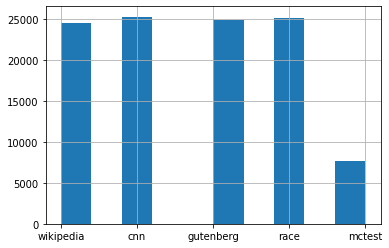

In [82]:
train_df["source"].hist()

Occurrences of 25 most popular stories:

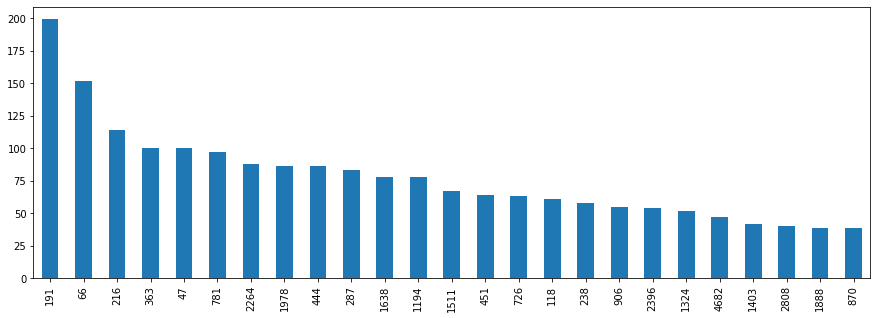

In [83]:
story_counts = train_df["p"].cat.codes.value_counts(sort=True)
story_counts[:25].plot(kind="bar", figsize=(15,5))

Occurrences of 25 least popular stories:

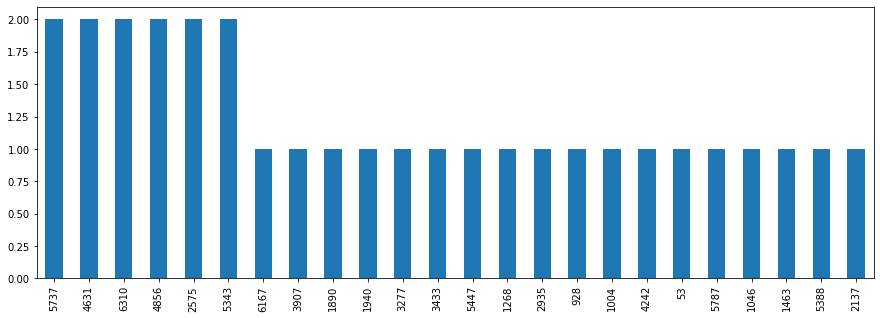

In [84]:
story_counts[-25:-1].plot(kind="bar", figsize=(15,5))

Histogram of story popularities:

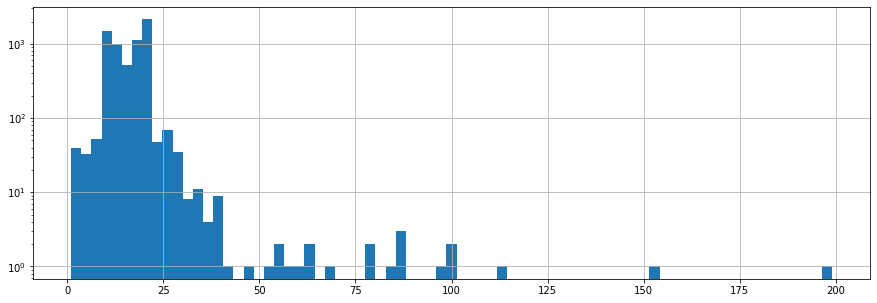

In [85]:
story_counts.hist(log=True,bins=75,figsize=(15,5))

### Removing rows with outlier story lengths to save memory

In [86]:
train_df.count()

source    107276
p         107276
q         107276
a         107276
span      107276
dtype: int64

LOGARITHMIC histogram of story length:

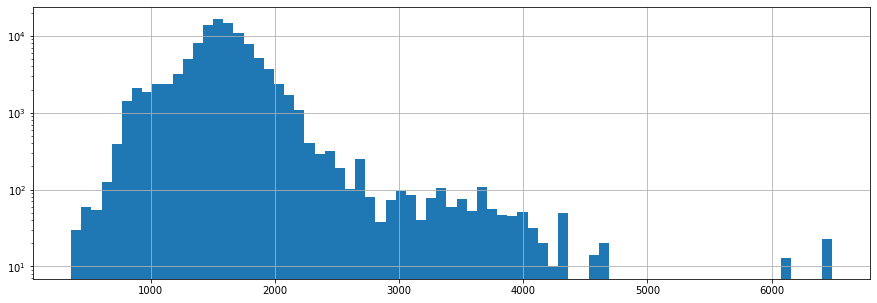

In [87]:
story_lengths = train_df["p"].str.len()
story_lengths.hist(log=True,bins=75,figsize=(15,5))

In [88]:
p_length_limit = story_lengths.quantile(0.999)
p_length_limit

4317.0

In [89]:
p_length_mask = story_lengths < p_length_limit
p_length_mask.value_counts()

True     107166
False       110
Name: p, dtype: int64

In [90]:
train_df = train_df[p_length_mask]
train_df.count()

source    107166
p         107166
q         107166
a         107166
span      107166
dtype: int64

### Removing rows with outlier question/answer/span lengths to save memory

LOGARITHMIC histogram of question length:

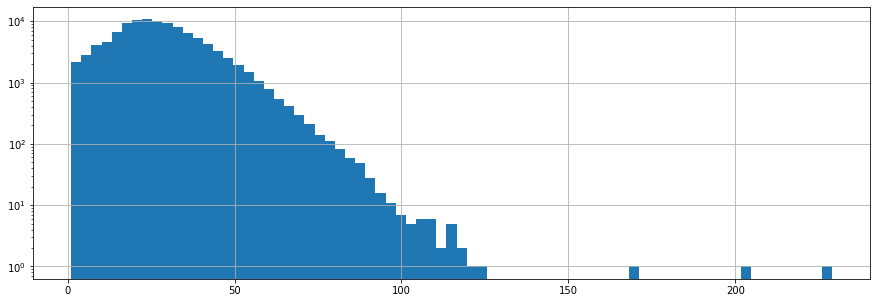

In [91]:
question_lengths = train_df["q"].str.len()
question_lengths.hist(log=True,bins=75,figsize=(15,5))

In [92]:
q_length_limit = question_lengths.quantile(0.999)
q_length_limit

89.0

LOGARITHMIC histogram of answer length:

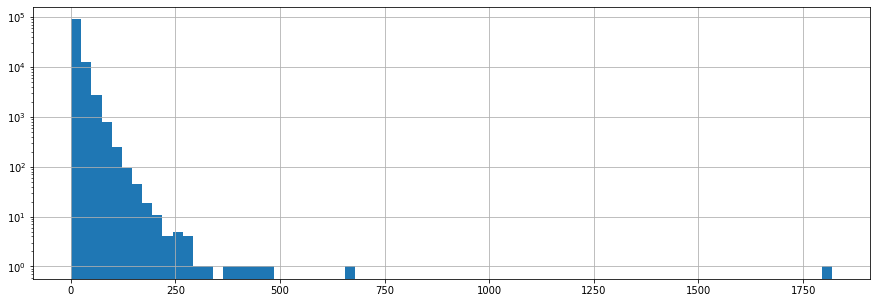

In [93]:
answer_lengths = train_df["a"].str.len()
answer_lengths.hist(log=True,bins=75,figsize=(15,5))

In [94]:
a_length_limit = answer_lengths.quantile(0.999)
a_length_limit

142.8350000000064

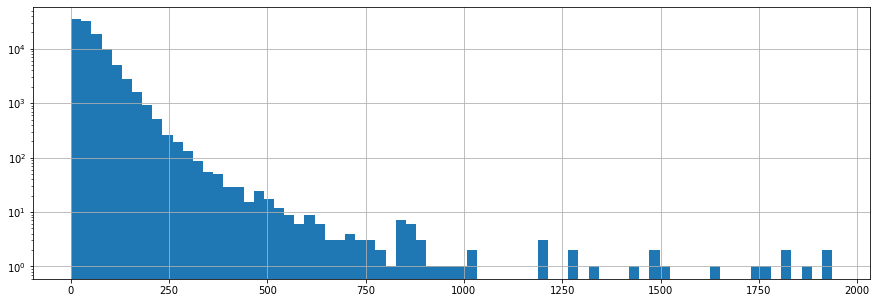

In [95]:
span_lengths = train_df["span"].str.len()
span_lengths.hist(log=True,bins=75,figsize=(15,5))

In [96]:
span_length_limit = span_lengths.quantile(0.999)
span_length_limit

502.5050000000192

In [97]:
bad_length_mask = (question_lengths > q_length_limit) | (answer_lengths > a_length_limit) | (span_lengths > span_length_limit)
bad_length_mask.value_counts()

False    106859
True        307
dtype: int64

In [98]:
excluded_stories = train_df["p"][bad_length_mask].unique()
len(excluded_stories)

272

In [99]:
excluded_mask = ~train_df["p"].isin(excluded_stories)
excluded_mask.value_counts()

True     102798
False      4368
Name: p, dtype: int64

In [100]:
train_df = train_df[excluded_mask]
train_df.count()

source    102798
p         102798
q         102798
a         102798
span      102798
dtype: int64

## Train-Validation-Test split

In [101]:
train_df = train_df.reset_index()

In [102]:
total_rows = len(train_df)
total_rows

102798

In [103]:
ideal_split_index = int(total_rows * 0.8)
ideal_split_index

82238

In [104]:
train_df[ ideal_split_index-3 : ideal_split_index+1 ]

,index,source,p,q,a,span
82235,85698,gutenberg,CHAPTER XVIII \n\nI \n\nTHOUGH he saw them twi...,Is she an adult?,yes,She had become secretary to Mr. Gruensberg of ...
82236,85699,gutenberg,CHAPTER XVIII \n\nI \n\nTHOUGH he saw them twi...,Who does she work for?,Gruensberg Leather Company,She had become secretary to Mr. Gruensberg of ...
82237,85700,gutenberg,CHAPTER XVIII \n\nI \n\nTHOUGH he saw them twi...,Who is her boss?,Mr. Gruensberg,She had become secretary to Mr. Gruensberg
82238,85701,gutenberg,CHAPTER XVIII \n\nI \n\nTHOUGH he saw them twi...,What is her job?,secretary,She had become secretary to Mr. Gruensberg


In [105]:
before_split_mask = pd.Series(np.linspace(0, total_rows, total_rows)) < ideal_split_index
before_split_mask.value_counts()

True     82238
False    20560
dtype: int64

In [106]:
split_story = train_df["p"][ideal_split_index - 1]
split_story_mask = train_df["p"] == split_story
split_story_mask.value_counts()

False    102780
True         18
Name: p, dtype: int64

In [107]:
train_mask = before_split_mask | split_story_mask
train_mask.value_counts()

True     82240
False    20558
dtype: int64

In [108]:
val_df = train_df[~train_mask]
train_df = train_df[train_mask]
len(val_df)

20558

In [109]:
train_df.memory_usage()

Index     657920
index     657920
source     82452
p         481552
q         657920
a         657920
span      657920
dtype: int64

In [110]:
val_df.memory_usage()

Index     164464
index     164464
source     20770
p         358188
q         164464
a         164464
span      164464
dtype: int64

In [111]:
test_df.memory_usage()

Index       128
source     8129
p         36378
q         63336
a         63336
span      63336
dtype: int64

## Utilities

In [112]:
import random
import gc
import torch
import transformers
from tqdm import tqdm
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader

In [113]:
def free_some_memory():
    torch.cuda.empty_cache()
    torch.cuda.reset_accumulated_memory_stats()
    gc.collect()

In [114]:
import json

if not os.path.exists("results"):
    os.makedirs("results")

def results_to_json(test_df, generated_df, model_name):
    '''
    Given the test dataframe, the dataframe resulting from generated_answers, and the name of the model, writes on a file (JSON format) the concatenation of the two DataFrames.

    Args:
        test_df: DataFrame already given as input for generation purposes
        generated_df: Output DataFrame of the method generate_answers()
        model_name: name of the model, it will define the path for the JSON file
    '''
    
    # drop answers column to avoid duplicate columns
    df_g = generated_df.copy().drop(columns=["answers"])
    
    final = pd.concat([test_df.copy(), df_g.copy()], axis=1)
    path = f"results/{model_name}.json"
    final.to_json(path_or_buf=path)

In [115]:
def results_from_json(model_name):
    '''
    Given the name of a model, returns the DataFrame loaded by a JSON file, containing the results previously savd on disk of the generate_answers() method.
    
    Args:
        model_Name: name of the model for which return the results
    '''

    # Opening JSON file
    with open(f'results/{model_name}.json') as f:

        # returns JSON object as a dictionary
        data = json.load(f)

        # Use pandas.DataFrame.from_dict() to Convert JSON to DataFrame
        df_results = pd.DataFrame.from_dict(data, orient="columns")

        return df_results

###Pytorch Dataset

In [116]:
class CreateDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

### Metric

Instead of importing the whole allennlp library, we decided to copy from the source code only of the functions necessary for our task.

In [117]:
#utility functions taken from the allennlp library for computing the F1-score
import collections
import re
import string
from typing import Callable, Sequence, TypeVar, Tuple

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_f1(a_pred: str, a_gold: str) -> float:
    pred_toks = get_tokens(a_pred)
    gold_toks = get_tokens(a_gold)
    common = collections.Counter(pred_toks) & collections.Counter(gold_toks)  # type: ignore[var-annotated]
    num_same = sum(common.values())
    if len(pred_toks) == 0 or len(gold_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return float(pred_toks == gold_toks)
    if num_same == 0:
        return 0.0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

###Generation

In [131]:
def generate_answers(model: torch.nn.Module,
                    tokenizer: any,
                    df_input: pd.DataFrame,
                    max_length: int,
                    history: bool = False,
                     ) -> pd.DataFrame:

    '''
    Given the model and the input, returns a dataframe cointaining the generated answers and relative F1-score
    
    Args:
        model: Torch model used to generate answers
        tokenizer: generic tokenizer
        df_input: dataframe containing the input to the model
        max_length: max length applied in the tokenization
        history: history flag.
    '''

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    if history:
      print('generation with history')
      df_input = transform_coqa_dataset_with_history(df_input)
      questions = df_input[["q", "history"]].apply(" ".join, axis=1)
    else:
      questions = df_input['q']
    input_values = tokenizer(list(questions),list(df_input['p']), 
                                padding=True, 
                                truncation=True, 
                                max_length = max_length)
                                
    input_ids, input_attention_mask = input_values['input_ids'], input_values['attention_mask']
    list_generated = []
    model.to(device)
    # Set the model in evaluation mode
    model.eval()
    for input, mask in zip(input_ids,input_attention_mask):
        input = np.expand_dims(np.array(input), axis=0)
        mask = np.expand_dims(np.array(mask), axis=0)
        generated = model.generate(input_ids=torch.tensor(input).to(device),
                                                        max_length=20,
                                                        repetition_penalty=5.,
                                                        min_length=1,
                                                        no_repeat_ngram_size=3,
                                                        early_stopping=True,
                                                        decoder_start_token_id = model.config.decoder_start_token_id,
                                                        num_beams=2,
                                                        )
        generated = tokenizer.batch_decode(generated, skip_special_tokens=True)
        list_generated.append(generated)

    # Create a dataframe and insert the real answers
    df_generated = pd.DataFrame(list_generated, columns = ['generated'])
    df_generated['answers'] = df_input['a']

    # Generate and insert the F1-score
    score = []
    for a_pred, a_gold in zip(df_generated['generated'], df_generated['answers']):
        score.append(compute_f1(a_pred, a_gold))
    df_generated['score'] = score

    # Print average f1_score and the answers with score greater than 0
    average_score = np.mean(score)*100
    predicted = len(df_generated[df_generated['score'] != 0])
    
    print(f'Average_score: {average_score}')
    print(f'N° of samples with score greater than 0: {predicted} / {len(df_generated)}')
    return df_generated

## Model definition

In this assignment to tackle the sequence to sequence task, we decided to use transformer-based encoder-decoder models - often also called seq2seq transformer models. The EncoderDecoderModel is initialized from a pretrained encoder checkpoint and a pretrained decoder checkpoint. To do so, the EncoderDecoderModel class provides a EncoderDecoderModel.from_encoder_decoder_pretrained() method.

In [119]:
def getModel(model_name):
  if(model_name != 'prajjwal1/bert-tiny') and (model_name != 'distilroberta-base'):
    raise Exception("ValueError: model name should be 'prajjwal1/bert-tiny' or 'distilroberta-base'.")
  
  # tie_encoder_decoder to share weights and half the number of parameters
  model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name,
                                                                          tie_encoder_decoder=True)
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  # set special tokens
  model.config.decoder_start_token_id = tokenizer.cls_token_id
  model.config.eos_token_id = tokenizer.sep_token_id
  model.config.pad_token_id = tokenizer.pad_token_id

  # set decoding parameters                             
  model.config.early_stopping = True
  model.config.no_repeat_ngram_size = 3
  model.config.repetition_penalty = 5.0
  model.config.num_beams = 2
  model.config.vocab_size = model.config.encoder.vocab_size
  return model, tokenizer


## Question generation $f_\theta(P, Q)$ with text passage $P$ and question $Q$

### Train Functionalities


In [120]:
# Train one epoch
def train(model: torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim,
          epoch: int) -> float:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        epoch: the number of the current epoch.

    Returns:
        the cross entropy Loss value on the training data.
    """    
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)
    loss_score = []
    loop = tqdm(train_loader)
    #set training mode
    model.train()
    for idx_batch, batch in enumerate(loop):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        loss, outputs = model(input_ids,
                              attention_mask=attention_mask,
                              labels = labels
                        )[:2]
        loss_score.append(loss.item())
        loss.backward()
        optimizer.step() 
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    loss_train = np.mean(loss_score)
    return loss_train

# Validate one epoch
def validate(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             device: torch.device) -> float:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation data.
        device: the device to use to evaluate the model.

    Returns:
        the loss value on the validation data.
    """
    loss_score = []
    #set evaluation mode
    model = model.eval()
    with torch.no_grad():
        for idx_batch, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            loss, outputs = model(input_ids,
                                  attention_mask=attention_mask,
                                  labels = labels
                            )[:2]
            loss_score.append(loss.item())
    loss_val = np.mean(loss_score)
    return loss_val

In [121]:
def training_loop(num_epochs: int,
                  optimizer: torch.optim, 
                  model: torch.nn.Module, 
                  loader_train: torch.utils.data.DataLoader, 
                  loader_val: torch.utils.data.DataLoader, 
                  verbose: bool=True) -> Dict:
    """Executes the training loop.
    
        Args:
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the validation loss for each epoch.
            the time of execution in seconds for the entire loop.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    loop_start = timer()
    train_losses_values = []
    val_losses_values = []
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train = train(model, loader_train, device, 
                                           optimizer, epoch)
        loss_val = validate(model, loader_val, device)
        time_end = timer()
        train_losses_values.append(loss_train)
        val_losses_values.append(loss_val)
        if verbose:            
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}') 
        
    return {'train_loss_values': train_losses_values,
            'val_loss_values' : val_losses_values,
            'time': time_loop}

### Encodings

In [122]:
BERT_TINY_ENCODER_MAX_LENGTH = 499
DISTILLROBERTA_ENCODER_MAX_LENGTH = 512
def encodings(model_name, 
              tokenizer,
              df,
              history):
  if(model_name == 'prajjwal1/bert-tiny'):
    encoder_max_length = BERT_TINY_ENCODER_MAX_LENGTH
    decoder_max_length = 50
  elif(model_name == 'distilroberta-base'):
    encoder_max_length = DISTILLROBERTA_ENCODER_MAX_LENGTH
    decoder_max_length = 25
  if history:
    #concatenating the question with the history 
    print(f'encoding with history')
    df = transform_coqa_dataset_with_history(df)
    questions = df[["q", "history"]].apply(" ".join, axis=1)
  else:
    questions = df['q']

  encodings = tokenizer(list(questions), list(df['p']), 
                            padding=True,
                            truncation= 'only_second',
                            max_length = encoder_max_length,
                            )
  input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']

  label_values = tokenizer(list(df['a']),
                            padding=True,
                            truncation=True,
                            max_length = decoder_max_length,
                            )
  labels, labels_mask = label_values['input_ids'], label_values['attention_mask']
  #Tokens with indices set to ``-100`` are ignored (masked) during training, the loss is only computed for the tokens with labels
  masked_labels = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels]

  # print(f"""
  #   Question 42 decoded: {tokenizer.decode(input_ids[42])}
  #   Answer 42 decoded: {tokenizer.decode(labels[42])}
  # """)

  #add the labels to the batch encodings dictionary, then this will be used to create a pytorch dataset
  if(model_name == 'prajjwal1/bert-tiny'):
    #token_type_ids are not relevant for the training process
    encodings.pop('token_type_ids')
  encodings.update({'labels': masked_labels})
  return encodings

### Execution

In [123]:
def execute(model_name: str,
            lr: float, 
            num_epochs: int, 
            batch_size: int,
            train_df: pd.DataFrame,
            val_df: pd.DataFrame,
            history:bool=False,
            ) ->Tuple[torch.nn.Module, any]:
    """Gets the model, does the encodings of the training and validation data using the 
        tokenizer, and then executes the training loop.

    Args:
        model: the network to train.
        lr: the learning rate.
        num_epochs: the number of epochs.
        batch_size: the batch size.
        train_df: training dataframe.
        val_df: validation dataframe.
        history: questions-answers history flag.
    """
    #get the model and the tokenizer
    model, tokenizer = getModel(model_name)
    #Start encodings
    print(f'STARTING ENCODING:')
    train_encodings = encodings(model_name, tokenizer, train_df, history)
    val_encodings = encodings(model_name, tokenizer, val_df, history)
    print(f'ENCODING COMPLETE.')

    #create training dataset
    train_dataset = CreateDataset(train_encodings)
    #create training dataloader
    data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle = True
                                        )
    #create validation dataset
    val_dataset = CreateDataset(val_encodings)
    #create validation dataloader
    data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                        batch_size=batch_size,
                                        shuffle = False
                                        )

    #Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    print(f'STARTING TRAINING:')
    statistics = training_loop(num_epochs, optimizer, model,
                               data_loader_train, data_loader_val)
    print(f'TRAINING COMPLETE.')
    return model, tokenizer


## Question generation $f_\theta(P, Q, H)$ with text passage $P$, question $Q$ and dialogue history $H$

## Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

In [124]:
#fix seed 42,2022,1337
fix_seed(42)
"""
#take a subset from the training set
max_train = len(train_df)
t_start = 0
t_end = 50000
train_df = train_df[t_start:t_end]
#take a subset from the validation set
max_val = len(val_df)
v_start = 0
v_end = 10000
val_df = val_df[v_start:v_end]
print(f'Training set shape: {(t_end-t_start)}\nValidation set shape: {(v_end-v_start)}')
"""
print(f'Training set shape: {len(train_df)}\nValidation set shape: {len(val_df)}')

Training set shape: 82240
Validation set shape: 20558


####Training

In [125]:
#parameters 
lr = 4e-5
num_epochs = 3
#if you are having runtime error reduce the batch size to 12 or 8
batch_size = 16
model_name = 'prajjwal1/bert-tiny'
#model_name = 'distilroberta-base'
history = True
#execute
model, tokenizer = execute(model_name, lr, num_epochs, batch_size, train_df, val_df, history=history)

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

STARTING ENCODING.
ENCODING COMPLETE.
STARTING ENCODING.
ENCODING COMPLETE.
STARTING TRAINING.


  0%|          | 0/5140 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Epoch 1: 100%|██████████| 5140/5140 [04:31<00:00, 18.95it/s, loss=3.92]


Epoch: 1  Lr: 0.00004000  Loss: Train = [4.1604] - Val = [3.7261]  Time one epoch (s): 290.4929 


Epoch 2: 100%|██████████| 5140/5140 [03:49<00:00, 22.39it/s, loss=3.94]


Epoch: 2  Lr: 0.00004000  Loss: Train = [3.6785] - Val = [3.5960]  Time one epoch (s): 246.0055 


Epoch 3: 100%|██████████| 5140/5140 [03:49<00:00, 22.42it/s, loss=3.17]


Epoch: 3  Lr: 0.00004000  Loss: Train = [3.3976] - Val = [3.3447]  Time one epoch (s): 245.6518 
Time for 3 epochs (s): 782.150
TRAINING COMPLETE.


In [ ]:
free_some_memory()

#### Evaluation

Encode test set using the tokenizer defined before.

In [132]:
if(model_name == 'prajjwal1/bert-tiny'):
  encoder_max_length = BERT_TINY_ENCODER_MAX_LENGTH
elif(model_name == 'distilroberta-base'):
  encoder_max_length = DISTILLROBERTA_ENCODER_MAX_LENGTH
print(f'STARTING GENERATION:')
df_generated = generate_answers(model = model, 
                                tokenizer = tokenizer,
                                df_input = test_df,
                                max_length = encoder_max_length,
                                history = history)
print(f'GENERATION COMPLETE.')

STARTING GENERATION:
generation with history
Average_score: 14.36837041503353
N° of samples with score greater than 0: 1453 / 7917
GENERATION COMPLETE.


Save the contents of df_generated (concatenated with test_df) in the folder "results", as a JSON file.

In [ ]:
# save
# results_to_json(test_df, df_generated, model_name)
# load
# df_results = results_from_json(model_name)

In [133]:
pd.set_option('display.max_rows', None)
#correct_answers = df_generated[df_generated['score'] != 0].reset_index(drop=True).sort_values('score',ascending=False)
correct_answers = df_generated[df_generated['score'] != 0].reset_index(drop=True)
correct_answers.head(50)

,generated,answers,score
0,in the woods,in a barn,0.500000
1,her mother,with her mommy and 5 sisters,0.250000
2,yes,Yes,1.000000
3,yes,Yes,1.000000
4,yes,yes,1.000000
5,yes,Yes,1.000000
6,yes,Yes,1.000000
7,she's mother,mother,0.666667
8,yes,Yes,1.000000
9,yes,Yes,1.000000


In [ ]:
# del tokenizer, input_values, input_ids, input_attention_mask, model, l, x, correct
del tokenizer, model, df_generated, correct_answers

free_some_memory()

## Conclusions

In [ ]:
# TODO